<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# TF-IDF Content-Based Recommendation on the COVID-19 Open Research Dataset
This demonstrates a simple implementation of Term Frequency Inverse Document Frequency (TF-IDF) content-based recommendation on the [COVID-19 Open Research Dataset](https://azure.microsoft.com/en-us/services/open-datasets/catalog/covid-19-open-research/), hosted through Azure Open Datasets.

In this notebook, we will create a recommender which will return the top k recommended articles similar to any article of interest (query item) in the COVID-19 Open Reserach Dataset.

In [1]:
# Set the environment path to find Recommenders
import sys
sys.path.append("../../")

# Import functions
from reco_utils.dataset import covid_utils
from reco_utils.recommender.tfidf.tfidf_utils import TfidfRecommender

# Print version
print("System version: {}".format(sys.version))

System version: 3.6.11 | packaged by conda-forge | (default, Nov 27 2020, 18:57:37) 
[GCC 9.3.0]


### 1. Load the dataset into a dataframe
Let's begin by loading the metadata file for the dataset into a Pandas dataframe. This file contains metadata about each of the scientific articles included in the full dataset.

In [2]:
# Specify container and metadata filename
container_name = 'covid19temp'
metadata_filename = 'metadata.csv'

# Get metadata (may take around 1-2 min)
metadata = covid_utils.load_pandas_df(container_name=container_name, metadata_filename=metadata_filename)

/home/scgraham/miniconda3/envs/reco_base/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### 2. Extract articles in the public domain
The dataset contains articles using a variety of licenses. We will only be using articles that fall under the public domain ([cc0](https://creativecommons.org/publicdomain/zero/1.0/)).

<AxesSubplot:title={'center':'License'}>

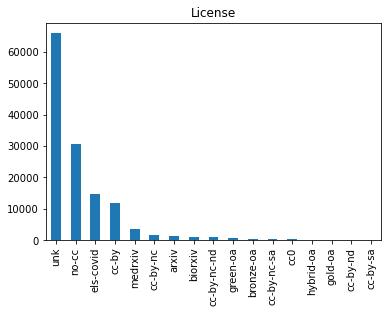

In [3]:
# View distribution of license types in the dataset
metadata['license'].value_counts().plot(kind='bar', title='License')

In [4]:
# Extract metadata on public domain articles only
metadata_public = metadata.loc[metadata['license']=='cc0']

# Clean dataframe
metadata_public = covid_utils.clean_dataframe(metadata_public)

Let's look at the top few rows of this dataframe which contains metadata on public domain articles.

In [5]:
# Preview metadata for public domain articles
print('Number of articles in dataset: ' + str(len(metadata)))
print('Number of articles in dataset that fall under the public domain (cc0): ' + str(len(metadata_public)))
metadata_public.head()

Number of articles in dataset: 134206
Number of articles in dataset that fall under the public domain (cc0): 274


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ej795nks,a3c3b7c38ad32e1042d78aae2027ca491e9f2197,PMC,Understanding the Spatial Clustering of Severe...,10.1289/ehp.7117,PMC1247620,15531441.0,cc0,We applied cartographic and geostatistical met...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,NaN,NaN,NaN,document_parses/pdf_json/a3c3b7c38ad32e1042d78...,document_parses/pmc_json/PMC1247620.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
1,9mzs5dl4,c1c6a98c21304f3788b20870b34afd8a115fa38c,PMC,The Application of the Haddon Matrix to Public...,10.1289/ehp.7491,PMC1257548,15866764.0,cc0,State and local health departments continue to...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,NaN,NaN,NaN,document_parses/pdf_json/c1c6a98c21304f3788b20...,document_parses/pmc_json/PMC1257548.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
2,u7lz3spe,c56ffdaf1cfbae5a6ed0abea495eaf7fa1cbc031,PMC,Cynomolgus Macaque as an Animal Model for Seve...,10.1371/journal.pmed.0030149,PMC1435788,16605302.0,cc0,BACKGROUND: The emergence of severe acute resp...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/c56ffdaf1cfbae5a6ed0a...,document_parses/pmc_json/PMC1435788.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
3,na7z92i8,f38f3b112e4b702b60ba56be806d418bbb2b83c3,PMC,Immune Protection of Nonhuman Primates against...,10.1371/journal.pmed.0030177,PMC1459482,16683867.0,cc0,BACKGROUND: Ebola virus causes a hemorrhagic f...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/f38f3b112e4b702b60ba5...,document_parses/pmc_json/PMC1459482.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
4,j35w1vsw,5dc0b8b662824323881c3a1ae3a1bae2a821484d,PMC,SARS: Systematic Review of Treatment Effects,10.1371/journal.pmed.0030343,PMC1564166,16968120.0,cc0,BACKGROUND: The SARS outbreak of 2002–2003 pre...,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,NaN,NaN,NaN,document_parses/pdf_json/5dc0b8b662824323881c3...,document_parses/pmc_json/PMC1564166.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN


### 3. Retrieve full article text
Now that we have the metadata for the public domain articles as its own dataframe, let's retrieve the full text for each public domain scientific article.

In [6]:
# Extract text from all public domain articles (may take 2-3 min)
all_text = covid_utils.get_public_domain_text(metadata_public, container_name)

Notice that **all_text** is the same as **metadata_public** but now has an additional column called **full_text** which contains the full text for each respective article.

In [7]:
# Preview
all_text.head()

,index,cord_uid,doi,title,publish_time,authors,journal,url,abstract,full_text
0,0,ej795nks,10.1289/ehp.7117,Understanding the Spatial Clustering of Severe...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,We applied cartographic and geostatistical met...,Since the emergence and rapid spread of the et...
1,1,9mzs5dl4,10.1289/ehp.7491,The Application of the Haddon Matrix to Public...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,State and local health departments continue to...,"sudden fever and dry cough, along with chills ..."
2,2,u7lz3spe,10.1371/journal.pmed.0030149,Cynomolgus Macaque as an Animal Model for Seve...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The emergence of severe acute resp...,The emergence of severe acute respiratory synd...
3,3,na7z92i8,10.1371/journal.pmed.0030177,Immune Protection of Nonhuman Primates against...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: Ebola virus causes a hemorrhagic f...,Background Ebola virus causes a hemorrhagic fe...
4,4,j35w1vsw,10.1371/journal.pmed.0030343,SARS: Systematic Review of Treatment Effects,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The SARS outbreak of 2002–2003 pre...,The SARS outbreak of 2002-2003 presented clini...


### 4. Instantiate the recommender
All functions for data preparation and recommendation are contained within the **TfidfRecommender** class we have imported. Prior to running these functions, we must create an object of this class.

Select one of the following tokenization methods to use in the model:

| tokenization_method | Description                                                                                                                      |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------|
| 'none'              | No tokenization is applied. Each word is considered a token.                                                                     |
| 'nltk'              | Simple stemming is applied using NLTK.                                                                                           |
| 'bert'              | HuggingFace BERT word tokenization ('bert-base-cased') is applied.                                                               |
| 'scibert'           | SciBERT word tokenization ('allenai/scibert_scivocab_cased') is applied.<br>This is recommended for scientific journal articles. |

In [8]:
# Create the recommender object
recommender = TfidfRecommender(id_col='cord_uid', tokenization_method='scibert')

### 5. Prepare text for use in the TF-IDF recommender
The raw text retrieved for each article requires basic cleaning prior to being used in the TF-IDF model.

Let's look at the full_text from the first article in our dataframe as an example.

In [9]:
# Preview the first 1000 characters of the full scientific text from one example
print(all_text['full_text'][0][:1000])

Since the emergence and rapid spread of the etiologic agent of severe acute respiratory syndrome (SARS)-SARS coronavirus (SARS-CoV)-in late 2002 and during the first 6 months of 2003, great progress has been made in understanding the biology, pathogenesis, and epidemiology of both the disease and the virus (SARS-CoV). Much remains to be done, however, including the development of effective therapeutic interventions and diagnostic tools with high sensitivity and specificity soon after the onset of clinical symptoms. The evaluation of key epidemiologic parameters and the impact of different public health interventions in the various settings that experienced minor or major epidemics is also needed (Affonso et al. 2004; Cui et al. 2003; Lau et al. 2004; Leung et al., in press) . In terms of outbreak control on the population level, many questions about "superspreading events" (SSEs) remain to be investigated. Such an SSE was responsible for > 300 cases (out of a total of 1,755) in the Amo

As seen above, there are some special characters (such as • ▲ ■ ≥ °) and punctuation which should be removed prior to using the text as input. Casing (capitalization) is preserved for [BERT-based tokenization methods](https://huggingface.co/transformers/model_doc/bert.html), but is removed for simple or no tokenization.

Let's join together the **title**, **abstract**, and **full_text** columns and clean them for future use in the TF-IDF model.

In [10]:
# Assign columns to clean and combine
cols_to_clean = ['title','abstract','full_text']
clean_col = 'cleaned_text'
df_clean = recommender.clean_dataframe(all_text, cols_to_clean, clean_col)

In [11]:
# Preview the dataframe with the cleaned text
df_clean.head()

,index,cord_uid,doi,title,publish_time,authors,journal,url,abstract,full_text,cleaned_text
0,0,ej795nks,10.1289/ehp.7117,Understanding the Spatial Clustering of Severe...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,We applied cartographic and geostatistical met...,Since the emergence and rapid spread of the et...,Understanding the Spatial Clustering of Severe...
1,1,9mzs5dl4,10.1289/ehp.7491,The Application of the Haddon Matrix to Public...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,State and local health departments continue to...,"sudden fever and dry cough, along with chills ...",The Application of the Haddon Matrix to Public...
2,2,u7lz3spe,10.1371/journal.pmed.0030149,Cynomolgus Macaque as an Animal Model for Seve...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The emergence of severe acute resp...,The emergence of severe acute respiratory synd...,Cynomolgus Macaque as an Animal Model for Seve...
3,3,na7z92i8,10.1371/journal.pmed.0030177,Immune Protection of Nonhuman Primates against...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: Ebola virus causes a hemorrhagic f...,Background Ebola virus causes a hemorrhagic fe...,Immune Protection of Nonhuman Primates against...
4,4,j35w1vsw,10.1371/journal.pmed.0030343,SARS: Systematic Review of Treatment Effects,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The SARS outbreak of 2002–2003 pre...,The SARS outbreak of 2002-2003 presented clini...,SARS Systematic Review of Treatment Effects BA...


In [12]:
# Preview the first 1000 characters of the cleaned version of the previous example
print(df_clean[clean_col][0][:1000])

Understanding the Spatial Clustering of Severe Acute Respiratory Syndrome SARS in Hong Kong We applied cartographic and geostatistical methods in analyzing the patterns of disease spread during the 2003 severe acute respiratory syndrome SARS outbreak in Hong Kong using geographic information system GIS technology We analyzed an integrated database that contained clinical and personal details on all 1755 patients confirmed to have SARS from 15 February to 22 June 2003 Elementary mapping of disease occurrences in space and time simultaneously revealed the geographic extent of spread throughout the territory Statistical surfaces created by the kernel method confirmed that SARS cases were highly clustered and identified distinct disease hot spots Contextual analysis of mean and standard deviation of different density classes indicated that the period from day 1 18 February through day 16 6 March was the prodrome of the epidemic whereas days 86 15 May to 106 4 June marked the declining phas

Let's also tokenize the cleaned text for use in the TF-IDF model. The tokens are stored within our TfidfRecommender object.

In [13]:
# Tokenize text with tokenization_method specified in class instantiation
tf, vectors_tokenized = recommender.tokenize_text(df_clean, text_col=clean_col)

### 6. Recommend articles using TF-IDF
Let's now fit the recommender model to the processed data (tokens) and retrieve the top k recommended articles.

When creating our object, we specified k=5 so the `recommend_top_k_items` function will return the top 5 recommendations for each public domain article.

In [14]:
# Fit the TF-IDF vectorizer
recommender.fit(tf, vectors_tokenized)

# Get recommendations
top_k_recommendations = recommender.recommend_top_k_items(df_clean, k=5)

In our recommendation table, each row represents a single recommendation.

- **cord_uid** corresponds to the article that is being used to make recommendations from.
- **rec_rank** contains the recommdation's rank (e.g., rank of 1 means top recommendation).
- **rec_score** is the cosine similarity score between the query article and the recommended article.
- **rec_cord_uid** corresponds to the recommended article.

In [15]:
# Preview the recommendations
top_k_recommendations

,cord_uid,rec_rank,rec_score,rec_cord_uid
0,ej795nks,1,0.142033,u7lz3spe
1,ej795nks,2,0.117743,j35w1vsw
2,ej795nks,3,0.100325,nt60lv2k
3,ej795nks,4,0.076779,vp9d9vmp
4,ej795nks,5,0.074392,05d1mhkq
...,...,...,...,...
1280,yetdnv6j,1,0.048499,9w9w0z4o
1281,yetdnv6j,2,0.046675,6nas74q1
1282,yetdnv6j,3,0.044476,7docv0dt
1283,yetdnv6j,4,0.040522,oj60pldq


Optionally, we can access the full recommendation dictionary, which contains full ranked lists for each public domain article.

In [16]:
# Optionally view full recommendation list
full_rec_list = recommender.recommendations

article_of_interest = 'ej795nks'
print('Number of recommended articles for ' + article_of_interest + ': ' + str(len(full_rec_list[article_of_interest])))

Number of recommended articles for ej795nks: 256


Optionally, we can also view the tokens and stop words which were used in the recommender.

In [17]:
# Optionally view tokens
tokens = recommender.get_tokens()

# Preview 10 tokens
print(list(tokens.keys())[:10])

['understanding', 'spatial', 'clustering', 'severe', 'acute', 'respiratory', 'syndrome', 'sa', 'rs', 'hon']


In [18]:
# Preview just the first 10 stop words sorted alphabetically
stop_words = list(recommender.get_stop_words())
stop_words.sort()
print(stop_words[:10])

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost']


### 7. Display top recommendations for article of interest
Now that we have the recommendation table containing IDs for both query and recommended articles, we can easily return the full metadata for the top k recommendations for any given article.

In [19]:
cols_to_keep = ['title','authors','journal','publish_time','url']
recommender.get_top_k_recommendations(metadata_public,article_of_interest,cols_to_keep)

,rank,similarity_score,title,authors,journal,publish_time,url
0,1,0.142033,Cynomolgus Macaque as an Animal Model for Severe Acute Respiratory Syndrome,"Lawler, James V; Endy, Timothy P; Hensley, Lisa E; Garrison, Aura; Fritz, Elizabeth A; Lesar, May; Baric, Ralph S; Kulesh, David A; Norwood, David A; Wasieloski, Leonard P; Ulrich, Melanie P; Slezak, Tom R; Vitalis, Elizabeth; Huggins, John W; Jahrling, Peter B; Paragas, Jason",PLoS Med,2006-04-18,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1435788/
1,2,0.117743,SARS: Systematic Review of Treatment Effects,"Stockman, Lauren J; Bellamy, Richard; Garner, Paul",PLoS Med,2006-09-12,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1564166/
2,3,0.100325,A Network Integration Approach to Predict Conserved Regulators Related to Pathogenicity of Influenza and SARS-CoV Respiratory Viruses,"Mitchell, Hugh D.; Eisfeld, Amie J.; Sims, Amy C.; McDermott, Jason E.; Matzke, Melissa M.; Webb-Robertson, Bobbi-Jo M.; Tilton, Susan C.; Tchitchek, Nicolas; Josset, Laurence; Li, Chengjun; Ellis, Amy L.; Chang, Jean H.; Heegel, Robert A.; Luna, Maria L.; Schepmoes, Athena A.; Shukla, Anil K.; Metz, Thomas O.; Neumann, Gabriele; Benecke, Arndt G.; Smith, Richard D.; Baric, Ralph S.; Kawaoka, Yoshihiro; Katze, Michael G.; Waters, Katrina M.",PLoS One,2013-07-25,https://doi.org/10.1371/journal.pone.0069374; https://www.ncbi.nlm.nih.gov/pubmed/23935999/
3,4,0.076779,Genome Wide Identification of SARS-CoV Susceptibility Loci Using the Collaborative Cross,"Gralinski, Lisa E.; Ferris, Martin T.; Aylor, David L.; Whitmore, Alan C.; Green, Richard; Frieman, Matthew B.; Deming, Damon; Menachery, Vineet D.; Miller, Darla R.; Buus, Ryan J.; Bell, Timothy A.; Churchill, Gary A.; Threadgill, David W.; Katze, Michael G.; McMillan, Leonard; Valdar, William; Heise, Mark T.; Pardo-Manuel de Villena, Fernando; Baric, Ralph S.",PLoS Genet,2015-10-09,https://doi.org/10.1371/journal.pgen.1005504; https://www.ncbi.nlm.nih.gov/pubmed/26452100/
4,5,0.074392,A Porcine Epidemic Diarrhea Virus Outbreak in One Geographic Region of the United States: Descriptive Epidemiology and Investigation of the Possibility of Airborne Virus Spread,"Beam, Andrea; Goede, Dane; Fox, Andrew; McCool, Mary Jane; Wall, Goldlin; Haley, Charles; Morrison, Robert",PLoS One,2015-12-28,https://doi.org/10.1371/journal.pone.0144818; https://www.ncbi.nlm.nih.gov/pubmed/26709512/


### Conclusion
In this notebook, we have demonstrated how to create a TF-IDF recommender to recommend the top k (in this case 5) articles similar in content to an article of interest (in this example, article with `cord_uid='ej795nks'`).